# Imports

In [114]:
#!wget http://purl.obolibrary.org/obo/go.obo
import ipyparallel as ipp
import requests,math,pickle
import networkx,obonet
import time
import numpy as np ,pandas as pd, matplotlib.pyplot as plt
import multiprocessing as mp
import scipy.stats as stats
from sklearn.metrics.cluster import *
from functools import partial
from IPython.display import clear_output
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

# Variables

In [2]:
dataset_name = "CAMI_Low"
num_cores = max(mp.cpu_count() - 1, 1)
!mkdir -p ./Output/{dataset_name}/figs
!mkdir -p ./Temp/{dataset_name}/

In [3]:
def to_biobox(df, path):
    df[df["bin_id"]!= 0].to_csv(path, index=None, sep='\t',header=None)    
    with open(path, 'r') as file:        
        text = file.read()
    with open(path, 'w', encoding='utf8') as file:
        file.write("@Version:0.9.1\n@SampleID:gsa\n\n@@SEQUENCEID\tBINID\n" + text)

# Read Fasta

In [4]:
def fasta_to_df(path):
    with open(path, 'r') as file:
        text = file.read()
    lines = [line for line in text.split('\n') if len(line) > 0]
    s = ''
    ids = []
    contigs = []
    for l in lines:
        if(l[0]=='>'):
            ids.append(l)        
            contigs.append(s)
            s = ''
        else:
            s += l    
    contigs.append(s)
    df = pd.DataFrame(
            {
                '#anonymous_gsa_id': ids,
                'contig': contigs[1:]
            })
    df['#anonymous_gsa_id'] = df['#anonymous_gsa_id'].apply(lambda x: x[1:])    
    return df

In [5]:
contigs = fasta_to_df(f"./Dataset/{dataset_name}/contigs.fna")
all_number = contigs.shape[0]
contigs["contig_length"] = contigs["contig"].apply(lambda x: len(x))
del contigs['contig']
contigs.head(2)

,#anonymous_gsa_id,contig_length
0,RL|S1|C0,809
1,RL|S1|C1,626


In [6]:
df = pd.read_csv(f"./Dataset/{dataset_name}/mapping.tsv", sep='\t')
contigs = pd.merge(contigs, df, how='inner', on='#anonymous_gsa_id')
contigs.head(2)

,#anonymous_gsa_id,contig_length,bin_id,tax_id,sequence_id,number_reads
0,RL|S1|C0,809,1220_AJ,75309,scaffold5.1_1_from_14912_to_15720_total_809,12
1,RL|S1|C1,626,1048993,328515,scaffold00001_11_from_606387_to_607012_total_626,16


# Save gold standard data as CAMI binning Bioboxes format.

In [7]:
path = f"./Temp/{dataset_name}/gold_standard"
contigs[['#anonymous_gsa_id', 'bin_id', 'tax_id',
         'contig_length']].to_csv(path, index=None, sep='\t')

with open(path, 'r') as file:
    file.readline()
    text = file.read()

with open(path, 'w', encoding='utf8') as file:
    file.write("@Version:0.9.1\n@SampleID:gsa\n\n@@SEQUENCEID\tBINID\tTAXID\t_LENGTH\n"+ text)

# Base Algorithms

In [8]:
def get_base_bin(bin_name, prob=0):
    try:
        df = pd.read_csv(f"./Binning/{dataset_name}/{bin_name}/prob{prob}/contigs.tab", sep='\t', header = None)
        df.columns = ['#anonymous_gsa_id','bin_id']
        df = df[df["bin_id"]!= 0]
        to_biobox(df, f"./Temp/{dataset_name}/{bin_name}_p{prob}")
        print(f'binned contigs: {df.shape[0]}', f'{round(df.shape[0]*100 / all_number,2)}% assigned')    
        display(df.head(2))
        return df
    except Exception as e:
        print(e)
        return None

In [9]:
base = get_base_bin('Metabat2',95) # Busybee, Metabat1, Metabat2, Maxbin2

binned contigs: 1687 8.65% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C6180,1
1,RL|S1|C7437,1


# Gene Ontology

In [10]:
go = pd.read_csv(f"./Annotation/{dataset_name}/cds.gene2go.tab.txt", sep='\t')
go = go.reset_index(drop=True)
go.head(2)

,#Gene,Contig,Start,End,Gene_Length,Strand,SP,TM,go_id,Taxonomy
0,RL|S1|C13963,1160,2104,945,1,No,0,GO:0016811,"hydrolase activity, acting on carbon-nitrogen ...",d__Bacteria;p__Actinobacteriota;c__Actinobacte...
1,RL|S1|C13963,1160,2104,945,1,No,0,GO:0019740,nitrogen utilization,d__Bacteria;p__Actinobacteriota;c__Actinobacte...


## Add namespace [ cc, bp, mf ]

In [11]:
go_graph = obonet.read_obo('./go.obo') 
accession_to_namespace = dict()
go_ids = go['TM'].unique()
for accession in go_ids:
    try:        
        accession_to_namespace[accession] =  go_graph.nodes[accession]['namespace']
    except: 
        accession_to_namespace[accession]= "unknown"

In [12]:
def get_namespace(accession):
    if(accession in accession_to_namespace):        
        return accession_to_namespace[accession]    
    return "unknown"

go['Namespace'] = go['TM'].apply(lambda x : get_namespace(x) )
print(go['Namespace'].value_counts())
go.head(2)

molecular_function    194760
biological_process    129305
cellular_component     78988
unknown                11250
Name: Namespace, dtype: int64


,#Gene,Contig,Start,End,Gene_Length,Strand,SP,TM,go_id,Taxonomy,Namespace
0,RL|S1|C13963,1160,2104,945,1,No,0,GO:0016811,"hydrolase activity, acting on carbon-nitrogen ...",d__Bacteria;p__Actinobacteriota;c__Actinobacte...,molecular_function
1,RL|S1|C13963,1160,2104,945,1,No,0,GO:0019740,nitrogen utilization,d__Bacteria;p__Actinobacteriota;c__Actinobacte...,biological_process


In [13]:
go = go[go['Namespace'] != "unknown"]

# Improver Method

## Create dictionary BP, CC , MF base of GOGO for each pair of go ids

In [27]:
def runGOGO(i,namespace):        
    %cd ./GOGO/
    !perl go_comb.pl ../Temp/{dataset_name}/{namespace}/go_ids{i}.txt ../Temp/{dataset_name}/{namespace}/go_ids_scores{i}
    %cd .. 

In [28]:
def Step1(namespace):    
    !rm -r ./Temp/{dataset_name}/{namespace}/ 
    !mkdir ./Temp/{dataset_name}/{namespace}/
    # first create all possible pairs of GOs for Biological Process
    go_ids = go[go["Namespace"] == namespace]['TM'].unique()    
    go1 = []
    go2 = []
    for i in range(0,go_ids.shape[0]):
        for j in range(i, go_ids.shape[0]):            
            go1.append(go_ids[i])
            go2.append(go_ids[j])
    df = pd.DataFrame({'goid1': go1,'goid2': go2},columns = ['goid1', 'goid2'])
    indexes = np.linspace(0,df.shape[0], num_cores + 1) // 1
    indexes[-1] =  df.shape[0]
    
    for i in range(0, num_cores):
        dfi = df.iloc[int(indexes[i]):int(indexes[i+1]),:]
        dfi.to_csv(f"./Temp/{dataset_name}/{namespace}/go_ids{i}.txt",sep=" ",index=None,header=None)
        
    # now run GOGO in multiprocessing
    if __name__ == '__main__':        
        pool = mp.Pool(num_cores)        
        pool.map(partial(runGOGO, namespace=namespace), range(0,num_cores))      
        
    clear_output()

In [29]:
def Step2(namespace):            
    def add2dict(row, dictionary):
        dictionary[row[0]+row[1]] = row[3]
        dictionary[row[1]+row[0]] = row[3]
    print('start reading files')            
    lines = []
    for i in range(0,num_cores):
        with open(f"./Temp/{dataset_name}/{namespace}/go_ids_scores{i}","r") as f:
            text = f.read()
            lines = [*lines, *[l for l in text.split("\n") if len(l) > 0 and l[-24:] != "not_in_the_same_ontology"]]                        
    print('files reading process was finished.')        
    print('start adding to dictionary')        
    df = pd.read_csv(StringIO('\n'.join(lines)), sep=" ", header=None)                
    dictionary = dict()    
    df.apply(lambda row:add2dict(row, dictionary), axis=1)
    print('adding to dictionary was finished')                   
    with open(f"./Temp/{dataset_name}/{namespace}.pkl", "wb") as file:
        pickle.dump(dictionary, file)        
    !rm -r ./Temp/{dataset_name}/{namespace}/    

### biological process

In [ ]:
Step1("biological_process")

rm: cannot remove './Temp/CAMI_Low/biological_process/': No such file or directory
/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO

/home/jupyter/Final/GOGO






/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO






/home/jupyter/Final/GOGO
/home/jupyter/Final/GOGO

/home/jupyter/Final/GOGO
/home/jupyter/Final/GOGO


In [286]:
Step2("biological_process")

### cellular component

In [287]:
Step1("cellular_component")

In [288]:
Step2("cellular_component")

### molecular function

In [289]:
Step1("molecular_function")

In [290]:
Step2("molecular_function")

## Load data

In [14]:
unlabelled = contigs[~contigs['#anonymous_gsa_id'].isin(base['#anonymous_gsa_id'])]
unlabelled = unlabelled[unlabelled['contig_length']>=1000]
number_of_bins = base['bin_id'].max() 
print(unlabelled.shape)
print(number_of_bins)

(6754, 6)
84


In [15]:
def standard_normalized(data):    
    data = (data - data.mean() ) / data.std()
    data -= data.min()
    data /= data.max()
    return data

bins = [0 for i in range(0,number_of_bins)]
for i in range(0, number_of_bins):    
    bins[i] = pd.merge(go, base[base['bin_id']==(i+1)], how="inner", 
                    left_on='#Gene',right_on="#anonymous_gsa_id")['TM']
bins_portion = [0 for i in range(0,number_of_bins)]    
for i in range(0, number_of_bins):    
    bins_portion[i] = bins[i].shape[0]
bins_portion = [base[base['bin_id'] == i].shape[0] for i in range(1, number_of_bins+1)]    
bins_portion = standard_normalized(np.array(sorted(bins_portion,reverse=True)))
bins_portion = [math.exp(-i)**1 for i in bins_portion]

In [16]:
#for i in range(0, number_of_bins):    
#    bins[i] = pd.Series(bins[i]['TM'].unique())    

go_rare = go.groupby("TM")["TM"].count()
go_rare = (go_rare - go_rare.mean()) / go_rare.std()
go_rare = go_rare - go_rare.min()
go_rare = go_rare / go_rare.max()
go_rare = go_rare.apply(lambda x : math.exp(-x)**1)

In [17]:
with open(f"./Temp/{dataset_name}/biological_process.pkl", "rb") as file:
    bp_dictionary = pickle.load(file)

with open(f"./Temp/{dataset_name}/cellular_component.pkl", "rb") as file:
    cc_dictionary = pickle.load(file)
    
with open(f"./Temp/{dataset_name}/molecular_function.pkl", "rb") as file:
    mf_dictionary = pickle.load(file)

# Visualization

In [57]:
taxs = contigs['bin_id'].unique()
taxsgo = {}
clens = []
tlens = []
tulens = []
for t in taxs:
    cnts = contigs[contigs['bin_id']==t]['#anonymous_gsa_id']
    clens.append(cnts.shape[0])
    taxsgo[t] = go[go['#Gene'].isin(cnts)]['TM']
    tlens.append(taxsgo[t].shape[0])
    tulens.append(taxsgo[t].unique().shape[0])

<BarContainer object of 60 artists>

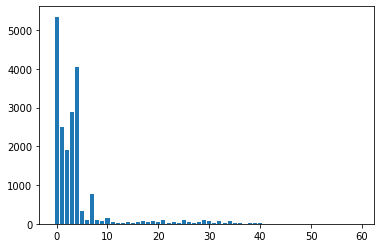

In [58]:
plt.bar([i for i in range(0,len(clens))],clens)

<BarContainer object of 60 artists>

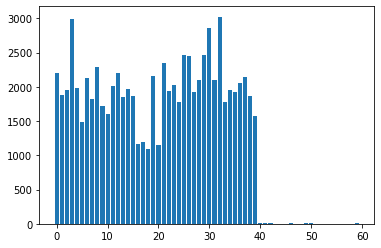

In [59]:
plt.bar([i for i in range(0,len(tulens))],tulens)

<BarContainer object of 60 artists>

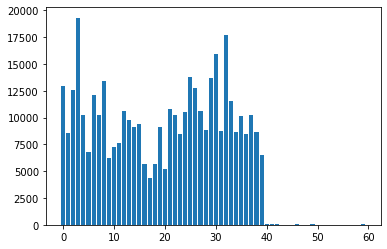

In [60]:
plt.bar([i for i in range(0,len(tlens))],tlens)

In [88]:
rtaxsgo = {}
for t in taxs:
    u = set(taxsgo[t])
    for tt in taxs:
        if( t != tt):
            u = u - set(taxsgo[tt])
    rtaxsgo[t] = u

<BarContainer object of 60 artists>

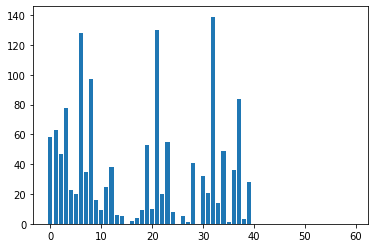

In [89]:
plt.bar([i for i in range(0,len(rtaxsgo))],[len(v)for v in rtaxsgo.values()])

In [93]:
nurtaxsgo = {}
for t in taxs:
    df = taxsgo[t]    
    nurtaxsgo[t] = df[df.isin(rtaxsgo[t])].shape[0]    

<BarContainer object of 60 artists>

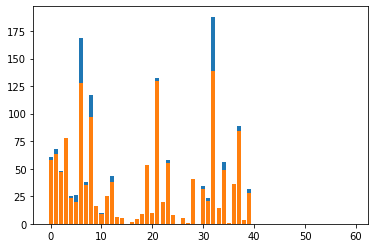

In [97]:
plt.bar([i for i in range(0,len(nurtaxsgo))],nurtaxsgo.values())
plt.bar([i for i in range(0,len(rtaxsgo))],[len(v)for v in rtaxsgo.values()])

In [116]:
for t in taxs:
    cnts = contigs[contigs['bin_id']==t]['#anonymous_gsa_id']    
    g = go[go['#Gene'].isin(cnts)]
    g = g[g['Namespace'] == "molecular_function"]    
    taxsgo[t] = g['TM'].unique()

In [124]:
mi = []
for t in taxs:
    d = []
    for g1 in taxsgo[t]:
        for g2 in taxsgo[t]:            
            if(g1 != g2):
                if(g1+g2 in mf_dictionary):
                    d.append(mf_dictionary[g1+g2])        
    mi.append(d)

In [ ]:
mo = []
for t1 in taxs:    
    d = []
    for t2 in taxs:
        if(t1!= t2):
            for g1 in taxsgo[t1]:
                for g2 in taxsgo[t2]:                                
                    if(g1+g2 in mf_dictionary):
                        d.append(mf_dictionary[g1+g2])       
        print(t2, end='\r')
    mo.append(d)
    print(t1)

1220_AJ9_201015
10489939_201015
10367439_201015
1365_A19_201015


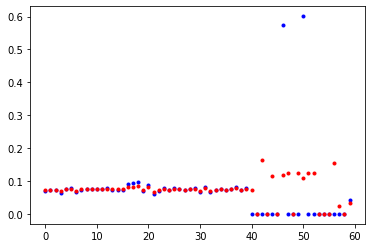

In [113]:
plt.plot([sum(i) / len(i) if len(i) >0 else 0 for i in mi],'b.')
plt.plot([sum(i) / len(i) if len(i) >0 else 0 for i in mo],'r.')

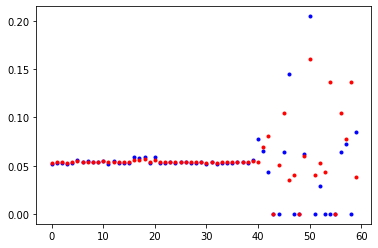

In [127]:
plt.plot([sum(i) / len(i) if len(i) >0 else 0 for i in mi],'b.')
plt.plot([sum(i) / len(i) if len(i) >0 else 0 for i in mo],'r.')

## Main loop

In [29]:
number = 5

def getDictionary(namespace):
    if(namespace == "biological_process"):
        return bp_dictionary
    if(namespace == "cellular_component"):
        return cc_dictionary    
    if(namespace == "molecular_function"):
        return mf_dictionary
    
# this function recived a contig and return pred bin and score
def binScore(inp_bin, go_id, dictionary,portion):        
    #go_id_rare = go_rare[go_id]
    def run(g):
        pair = g +  go_id                
        if(pair in dictionary):                                          
            return  dictionary[pair] * portion #* go_rare[g] * go_id_rare         
        return 0                
    scores = inp_bin.apply(lambda g: run(g))            
    #scores = scores[scores >= 0]            
    if(scores.shape[0] == 0):
        return 0    
    st = sorted(scores,reverse=True)[:number]    
    print(st)
    return sum(st) / len(st)

def getScore(go_id):            
    result = np.zeros(number_of_bins)    
    namespace = accession_to_namespace[go_id]    
    for i in range(0,number_of_bins):
        result[i] = binScore(bins[i], go_id, getDictionary(namespace),bins_portion[i])    
    return go_id, result

if __name__ == '__main__':
    pool = mp.Pool(num_cores)    
    go_ids = pd.merge(unlabelled, go, how='inner',
             left_on='#anonymous_gsa_id',right_on='#Gene')['TM'].unique()    
    go_dictionary = dict()
    for go_id, result in pool.map(getScore, go_ids):                
        go_dictionary[go_id] = result

[0.12471113055711897, 0.10043108743980377, 0.10043108743980377, 0.10043108743980377, 0.10043108743980377][0.36787944117144233, 0.36787944117144233, 0.36787944117144233, 0.36787944117144233, 0.20343733096780764][0.2207276647028654, 0.1964476215855502, 0.1964476215855502, 0.1824682028210354, 0.1729033373505779][0.36787944117144233, 0.21153067867357933, 0.21153067867357933, 0.21153067867357933, 0.2078518842618649]
[0.36787944117144233, 0.1710639401447207, 0.15193420920380568, 0.15193420920380568, 0.15193420920380568][0.36787944117144233, 0.36787944117144233, 0.36787944117144233, 0.2865780846725536, 0.22734949464395135][0.2457434667025235, 0.2457434667025235, 0.11956081838071876, 0.11956081838071876, 0.09196986029286058]

[0.22734949464395135, 0.21704887029115097, 0.20564460761483627, 0.20564460761483627, 0.20564460761483627]


[0.24163683654950016, 0.24163683654950016, 0.24163683654950016, 0.24163683654950016, 0.24163683654950016][0.3090187305840115, 0.3090187305840115, 0.3090187305840115

[0.44958184475550733, 0.44958184475550733, 0.44958184475550733, 0.44958184475550733, 0.44958184475550733][0.6541150883031129, 0.6541150883031129, 0.6541150883031129, 0.6541150883031129, 0.4567095117819689][0.8364643072929833, 0.8364643072929833, 0.8364643072929833, 0.8364643072929833, 0.5353371566675093][0.4575459760892619, 0.4575459760892619, 0.4575459760892619, 0.4575459760892619, 0.4575459760892619]
[0.8071177470053893, 0.3309182762722096, 0.3309182762722096, 0.23729261761958445, 0.23729261761958445]
[0.44834486870903906, 0.44834486870903906, 0.44834486870903906, 0.44834486870903906, 0.44834486870903906]


[0.3847735813547723, 0.3847735813547723, 0.3847735813547723, 0.3847735813547723, 0.3847735813547723]
[0.34771030315360396, 0.25341598365432155, 0.25341598365432155, 0.25341598365432155, 0.25341598365432155][0.4324615653621168, 0.3961415510836577, 0.3961415510836577, 0.29562802319675946, 0.29562802319675946][0.13467075347417032, 0.13467075347417032, 0.12714257470853346, 0.127142574

[0.9340906234779491, 0.6108952677545788, 0.45396804301028326, 0.45396804301028326, 0.45396804301028326][0.43435213991724636, 0.385779427496393, 0.31011808699467913, 0.31011808699467913, 0.31011808699467913]
[0.9340906234779491, 0.5548498303459017, 0.5548498303459017, 0.5548498303459017, 0.5109475710424383][0.9340906234779491, 0.9340906234779491, 0.9340906234779491, 0.9340906234779491, 0.9340906234779491]


[0.9340906234779491, 0.8098565705553818, 0.8098565705553818, 0.7977133924501686, 0.7977133924501686][0.9401758829606263, 0.4522245997040612, 0.4522245997040612, 0.4409424891085337, 0.39017299142865985][0.9220380095481409, 0.9220380095481409, 0.46378511880271484, 0.3771135459051896, 0.3771135459051896]

[0.49880439293722484, 0.4390225930346361, 0.384845336872915, 0.384845336872915, 0.384845336872915]

[0.8406815611301542, 0.8406815611301542, 0.788372486215389, 0.7304588675597562, 0.7304588675597562]

[0.9340906234779491, 0.5884770927911079, 0.5884770927911079, 0.42968168679985663, 0.4

[0.9586705556032091, 0.6039624500300218, 0.44098845557747623, 0.44098845557747623, 0.44098845557747623]

[0.8628035000428882, 0.8628035000428882, 0.7496803744817095, 0.7496803744817095, 0.5934170739183865][0.9586705556032091, 0.9586705556032091, 0.9586705556032091, 0.6135491555860538, 0.6135491555860538]
[0.26555174390208897, 0.15434595945211668, 0.15434595945211668, 0.15434595945211668, 0.1457179244516878]
[0.9586705556032091, 0.9586705556032091, 0.9586705556032091, 0.9586705556032091, 0.9586705556032091]



[0.9586705556032091, 0.9586705556032091, 0.6403919311429437, 0.6403919311429437, 0.6403919311429437]

[0.5138474178033201, 0.4572858550227307, 0.45536851391152433, 0.45536851391152433, 0.45536851391152433][0.9586705556032091, 0.5512355694718452, 0.5416488639158131, 0.5416488639158131, 0.5416488639158131]

[0.48892198335763665, 0.3930549277973157, 0.3930549277973157, 0.3930549277973157, 0.3930549277973157][0.9586705556032091, 0.8282913600411727, 0.6355985783649277, 0.63559857836492

[0.8365821237708448, 0.824038216494004, 0.824038216494004, 0.5635109115134641, 0.5635109115134641][0.2660003884744601, 0.2660003884744601, 0.2660003884744601, 0.2660003884744601, 0.2660003884744601][0.9743603973423447, 0.6177444919150465, 0.6177444919150465, 0.5329751373462626, 0.5329751373462626]
[0.6088619608989655, 0.5171949461835904, 0.5171949461835904, 0.5171949461835904, 0.5171949461835904][0.6966676840997764, 0.45112886396950563, 0.4365134580093704, 0.4150775292678388, 0.3975390421156766]
[0.8350268605223894, 0.8350268605223894, 0.8350268605223894, 0.6382060602592358, 0.6382060602592358]
[0.96491594437237, 0.96491594437237, 0.96491594437237, 0.96491594437237, 0.96491594437237]


[0.5845623696592892, 0.5845623696592892, 0.39492173468620884, 0.39492173468620884, 0.39492173468620884]


[0.9680538796418466, 0.9680538796418466, 0.9680538796418466, 0.9680538796418466, 0.9680538796418466][0.9743603973423447, 0.602154725557569, 0.5748726344319833, 0.5446674621143708, 0.5446674621143708]

[0.9807079997038756, 0.5227173638421657, 0.4854504598534184, 0.441318599866744, 0.4118973598756277][0.721196714453753, 0.721196714453753, 0.4781740835259536, 0.4781740835259536, 0.4781740835259536]
[0.9807079997038756, 0.9807079997038756, 0.8473317117441485, 0.8473317117441485, 0.8473317117441485]
[0.4407859864601383, 0.4191402460536136, 0.40438178668552865, 0.40438178668552865, 0.4014300948119116][0.9838972912056658, 0.6965992821736113, 0.5559019695312012, 0.5559019695312012, 0.5559019695312012]

[0.5499985857839672, 0.5499985857839672, 0.5499985857839672, 0.5499985857839672, 0.5499985857839672]


[0.397494505647089, 0.397494505647089, 0.397494505647089, 0.397494505647089, 0.397494505647089]

[0.4437376783337553, 0.4053656839767343, 0.4053656839767343, 0.4053656839767343, 0.403397889394323]

[0.5903383747233995, 0.5903383747233995, 0.5903383747233995, 0.5254011535038255, 0.5254011535038255]
[0.9807079997038756, 0.7982963117589547, 0.6757078117959702, 0.6717849797971548, 0.525659487841

[0.5922581726268065, 0.5922581726268065, 0.5271097736378578, 0.5271097736378578, 0.5271097736378578][0.9870969543780108, 0.8034969208637007, 0.5093420284590536, 0.4935484771890054, 0.47479363505582317][0.6593807655245113, 0.6593807655245113, 0.3208065101728535, 0.3208065101728535, 0.23098068732445454]
[0.7778324000498725, 0.7778324000498725, 0.4441936294701049, 0.4145807208387645, 0.4145807208387645][0.9870969543780108, 0.5399420340447719, 0.40767104215811845, 0.40767104215811845, 0.40767104215811845][0.9903070229498908, 0.5535816258289891, 0.5535816258289891, 0.5535816258289891, 0.5535816258289891][0.454064599013885, 0.454064599013885, 0.454064599013885, 0.454064599013885, 0.454064599013885][0.9870969543780108, 0.9870969543780108, 0.9870969543780108, 0.6593807655245113, 0.4767678289645792]
[0.9870969543780108, 0.9870969543780108, 0.6988646436996316, 0.5675807487673562, 0.5675807487673562][0.2754912415375865, 0.2754912415375865, 0.1584074638841122, 0.1584074638841122, 0.158407463884112

[0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.7486721093501174][0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.7140113635468712, 0.6189418893436818][0.9903070229498908, 0.9903070229498908, 0.6278546525502308, 0.5882423716322351, 0.5882423716322351][0.4000840372717559, 0.4000840372717559, 0.4000840372717559, 0.4000840372717559, 0.4000840372717559][0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.9903070229498908][0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.5476397836912896, 0.5476397836912896]
[0.7097227101977898, 0.25960649900141686, 0.18360003351431, 0.17866454874241997, 0.17866454874241997]
[0.4089968004783049, 0.4089968004783049, 0.4089968004783049, 0.4089968004783049, 0.4089968004783049]



[0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.9903070229498908][0.9903070229498908, 0.8585961888975553, 0.8585961888975553, 0.8457221975992067, 0.5783393014

[0.9935275307599738, 0.5553818896948254, 0.5553818896948254, 0.5553818896948254, 0.5553818896948254][0.6636763905476626, 0.6636763905476626, 0.5176278435259464, 0.3228964474969915, 0.3228964474969915][0.8941747776839765, 0.7769385290542995, 0.7769385290542995, 0.7769385290542995, 0.4600032467418679]
[0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.9903070229498908]

[0.5712783301869849, 0.5712783301869849, 0.5613430548793852, 0.5613430548793852, 0.5613430548793852]
[0.9935275307599738, 0.9935275307599738, 0.4967637653799869, 0.46497088439566775, 0.42324272810374886][0.4476187743733507, 0.34363653696361207, 0.31491763329806527, 0.3060048700915163, 0.2861987296325184][0.5139693449109933, 0.4555412305569498, 0.4555412305569498, 0.4555412305569498, 0.4555412305569498][0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.8269063641631588]

[0.9935275307599738, 0.6358576196863832, 0.6358576196863832, 0.6358576196863832, 0.6358576

[0.996758511756972, 0.8970826605812748, 0.8970826605812748, 0.8970826605812748, 0.8970826605812748][0.457022664149588, 0.4083398151423492, 0.4083398151423492, 0.4083398151423492, 0.4083398151423492][0.996758511756972, 0.996758511756972, 0.996758511756972, 0.996758511756972, 0.996758511756972]



[0.228511332074794, 0.228511332074794, 0.16194498751387573, 0.16194498751387573, 0.16194498751387573]
[0.5452269059310637, 0.5452269059310637, 0.4774473271315896, 0.4116612653556294, 0.4116612653556294]
[0.48285437994934727, 0.41330745279614906, 0.29110356651267233, 0.21857605676719424, 0.09339158789143753][0.41032687020386915, 0.41032687020386915, 0.41032687020386915, 0.41032687020386915, 0.2573236304668332][0.5325307564873459, 0.47192557711098754, 0.47192557711098754, 0.3924433746501897, 0.3348187778661112]
[0.46397735686490776, 0.36561813131967036, 0.3348187778661112, 0.30600647947407195, 0.28613592885887246][0.40734628761158925, 0.40734628761158925, 0.40734628761158925, 0.40734628761158925,

[0.5452269059310637, 0.47645056861983265, 0.4614991909434781, 0.4116612653556294, 0.4116612653556294]
[0.996758511756972, 0.996758511756972, 0.7764748806586813, 0.6159967602658087, 0.5960615900306693]

[0.27610210775668126, 0.2681280396626255, 0.2541734204980279, 0.18041329062801192, 0.17841977360449798]
[0.7575364689352988, 0.6279578624068924, 0.6279578624068924, 0.5173176676018685, 0.45850891540820715][0.3877390610734621, 0.3777714759558924, 0.3777714759558924, 0.36082658125602385, 0.3359076184620996][0.5980551070541832, 0.532269045278223, 0.532269045278223, 0.532269045278223, 0.532269045278223]
[1.0, 1.0, 0.64, 0.64, 0.64]

[0.996758511756972, 0.996758511756972, 0.40867098982035854, 0.40867098982035854, 0.40867098982035854][0.2721150737096534, 0.2721150737096534, 0.2252674236570757, 0.1574878448576016, 0.1535008108105737]
[0.996758511756972, 0.4485413302906374, 0.4116612653556294, 0.4116612653556294, 0.4116612653556294][0.996758511756972, 0.5512074570016056, 0.5512074570016056, 0.55

[1.0, 0.857, 0.857, 0.857, 0.857][0.7834521902409801, 0.6947406826946094, 0.6608508932948725, 0.6518800666890597, 0.5601782836074184][1.0, 1.0, 1.0, 1.0, 1.0]

[1.0, 0.547, 0.547, 0.547, 0.478][0.273, 0.273, 0.273, 0.273, 0.273][0.163, 0.163, 0.163, 0.163, 0.144]

[0.18614699723274983, 0.18614699723274983, 0.18614699723274983, 0.18614699723274983, 0.18614699723274983][0.42, 0.42, 0.386, 0.33, 0.33]
[1.0, 1.0, 0.689, 0.683, 0.673]

[0.6493274254850195, 0.6493274254850195, 0.6493274254850195, 0.39154443756746676, 0.3415462258051203]
[0.9, 0.9, 0.782, 0.782, 0.782]


[0.285, 0.285, 0.226, 0.17, 0.17][1.0, 1.0, 1.0, 1.0, 0.685][0.405, 0.405, 0.35, 0.35, 0.35]
[0.71, 0.483, 0.483, 0.467, 0.467]


[0.296, 0.268, 0.246, 0.246, 0.246][0.46, 0.46, 0.46, 0.46, 0.46]
[0.854, 0.854, 0.584, 0.23, 0.207]


[0.2210998902243166, 0.2210998902243166, 0.2210998902243166, 0.2210998902243166, 0.18658034214581656][0.36787944117144233, 0.2615622826728955, 0.2615622826728955, 0.2615622826728955, 0.26156228267

[0.42292969943082404, 0.3777311055985222, 0.3777311055985222, 0.3777311055985222, 0.3777311055985222][0.8364643072929833, 0.8364643072929833, 0.8364643072929833, 0.8364643072929833, 0.8364643072929833]
[0.8364643072929833, 0.548720585584197, 0.548720585584197, 0.548720585584197, 0.548720585584197]
[0.36787944117144233, 0.26818411261398145, 0.19129730940915002, 0.19129730940915002, 0.19129730940915002][0.776276309489418, 0.776276309489418, 0.605495521401746, 0.5286441667622936, 0.5286441667622936][0.776276309489418, 0.776276309489418, 0.776276309489418, 0.776276309489418, 0.776276309489418]

[0.8364643072929833, 0.4148862964173197, 0.4148862964173197, 0.4148862964173197, 0.4148862964173197]

[0.674009784979691, 0.674009784979691, 0.6703216329414984, 0.6703216329414984, 0.6703216329414984][0.3058528659388307, 0.29964265546291535, 0.29653755022495765, 0.269367879392828, 0.269367879392828][0.8071177470053893, 0.6214806651941498, 0.20742926098038506, 0.20742926098038506, 0.1291388395208623]

[0.8419135669578789, 0.6137549903122937, 0.43779505481809705, 0.3898059815014979, 0.3898059815014979][0.9220380095481409, 0.9220380095481409, 0.48314791700322585, 0.48314791700322585, 0.48314791700322585][0.5217976150431476, 0.5217976150431476, 0.5217976150431476, 0.5217976150431476, 0.5217976150431476]
[0.9220380095481409, 0.9220380095481409, 0.9220380095481409, 0.9220380095481409, 0.9220380095481409][0.910140911045733, 0.6580318786860649, 0.6389189195541045, 0.6389189195541045, 0.6389189195541045][0.9220380095481409, 0.9220380095481409, 0.726565951523935, 0.726565951523935, 0.726565951523935]


[0.627907884502284, 0.627907884502284, 0.627907884502284, 0.627907884502284, 0.627907884502284][0.6345716001234738, 0.6098369544197362, 0.4742228624578648, 0.43754735331094363, 0.43754735331094363][0.9340906234779491, 0.9340906234779491, 0.9340906234779491, 0.9340906234779491, 0.9340906234779491][0.6750078887593927, 0.6750078887593927, 0.49652479018447593, 0.49652479018447593, 0.49652479018447

[0.9586705556032091, 0.9586705556032091, 0.9586705556032091, 0.9586705556032091, 0.7381763278144711][0.37004683446283876, 0.37004683446283876, 0.3662121522404259, 0.33265868279431354, 0.2856838255697563][0.9586705556032091, 0.9586705556032091, 0.6288878844757052, 0.6288878844757052, 0.6288878844757052][0.40819760245986375, 0.34654762131031913, 0.3054476338772894, 0.3054476338772894, 0.3054476338772894]
[0.706337368828394, 0.706337368828394, 0.706337368828394, 0.706337368828394, 0.6788054014950292]

[0.4866648194256875, 0.4866648194256875, 0.4866648194256875, 0.4866648194256875, 0.4866648194256875][0.4888914591395257, 0.4888914591395257, 0.4888914591395257, 0.4888914591395257, 0.4888914591395257][0.9586705556032091, 0.7554323978153288, 0.7554323978153288, 0.7554323978153288, 0.7554323978153288]
[0.5723263216951159, 0.5723263216951159, 0.5723263216951159, 0.5023433711360816, 0.5023433711360816][0.8252142590261657, 0.8252142590261657, 0.8252142590261657, 0.8252142590261657, 0.825214259026

[0.1159991372279883, 0.1159991372279883, 0.1159991372279883, 0.11408179611678188, 0.11408179611678188]

[0.5924615193008369, 0.5924615193008369, 0.5924615193008369, 0.4193396467778651, 0.4193396467778651]




[0.716897547783533, 0.716897547783533, 0.716897547783533, 0.7129747157847175, 0.6423637398060386]

[0.9586705556032091, 0.9586705556032091, 0.6988708350347395, 0.4985086889136688, 0.4985086889136688][0.496238247850161, 0.496238247850161, 0.496238247850161, 0.496238247850161, 0.41876231587355484]
[0.17946956394580924, 0.17946956394580924, 0.10395504796861081, 0.10101292396949918, 0.10101292396949918][0.33323125589108193, 0.2981542815867575, 0.2981542815867575, 0.24748754092495556, 0.21046184582594646][0.9680538796418466, 0.9680538796418466, 0.9680538796418466, 0.9680538796418466, 0.9680538796418466]
[0.5072602329323277, 0.5072602329323277, 0.5072602329323277, 0.45304921567238426, 0.45304921567238426][0.9680538796418466, 0.9680538796418466, 0.9680538796418466, 0.9680538796418466, 0.

[0.7018259345627657, 0.5162517071396997, 0.5162517071396997, 0.5162517071396997, 0.5162517071396997][0.545079099327939, 0.4978520293500669, 0.4978520293500669, 0.4978520293500669, 0.4978520293500669][0.9807079997038756, 0.9807079997038756, 0.9807079997038756, 0.9807079997038756, 0.9807079997038756][0.9838972912056658, 0.9838972912056658, 0.6454366230309168, 0.6454366230309168, 0.6454366230309168][0.11594888728373902, 0.08087191297941461, 0.04774365946977489, 0.04774365946977489, 0.0370256950990091]
[0.6041161278175874, 0.42758868787088977, 0.42758868787088977, 0.42758868787088977, 0.42758868787088977]
[0.9838972912056658, 0.9838972912056658, 0.9838972912056658, 0.9838972912056658, 0.9838972912056658][0.4141031688704965, 0.38584671734756854, 0.3595389866193252, 0.3595389866193252, 0.3225132915203161]

[0.9838972912056658, 0.7753110654700647, 0.7753110654700647, 0.7753110654700647, 0.7753110654700647]
[0, 0, 0, 0, 0][0.7113577415416964, 0.6906958984263774, 0.6906958984263774, 0.690695898

[0, 0, 0, 0, 0][0.9870969543780108, 0.9870969543780108, 0.4175420117018986, 0.38891620002493626, 0.38891620002493626]


[0.9870969543780108, 0.9870969543780108, 0.9870969543780108, 0.9870969543780108, 0.9870969543780108][0.7176194858328139, 0.7176194858328139, 0.7176194858328139, 0.7176194858328139, 0.7176194858328139][0.36720006702862, 0.3188323162640975, 0.3020516680396713, 0.3020516680396713, 0.3020516680396713]


[0.73440013405724, 0.5429033249079059, 0.3760839396180221, 0.3750968426636441, 0.3119226375834514]
[0.418156348762408, 0.3748648679493587, 0.341412360048366, 0.3256700033890754, 0.32468610609786974][0.48960008937149335, 0.48960008937149335, 0.48960008937149335, 0.48960008937149335, 0.48960008937149335]



[0.9870969543780108, 0.9870969543780108, 0.9870969543780108, 0.9870969543780108, 0.9870969543780108][0.7041082933173723, 0.7041082933173723, 0.5773489943797863, 0.5773489943797863, 0.5773489943797863]

[0.5010953536126448, 0.5010953536126448, 0.5010953536126448, 0.5010953

[0.9903070229498908, 0.5971551348387841, 0.5209014940716425, 0.5209014940716425, 0.5209014940716425]


[0.6080517238968547, 0.6080517238968547, 0.43037427210881274, 0.43037427210881274, 0.43037427210881274][0.5496203977371894, 0.5496203977371894, 0.5496203977371894, 0.5496203977371894, 0.5496203977371894][0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.9903070229498908][0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.715991977592771]
[0, 0, 0, 0, 0][0.9903070229498908, 0.9903070229498908, 0.5912132927010848, 0.5912132927010848, 0.5912132927010848]
[0.9903070229498908, 0.5218918010945924, 0.5218918010945924, 0.42385140582255326, 0.390180967042257]


[0.7531549761904223, 0.7531549761904223, 0.6978775467452536, 0.6208839843037688, 0.48170331373646924][0.4644539937634988, 0.4644539937634988, 0.4644539937634988, 0.4644539937634988, 0.4644539937634988]
[0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.4109774145

[0.6517540601785429, 0.6517540601785429, 0.6517540601785429, 0.6517540601785429, 0.6517540601785429]
[0.7001470652255728, 0.7001470652255728, 0.4208804847537036, 0.4208804847537036, 0.4208804847537036]
[0.5235890087105062, 0.42522978316526877, 0.4202621455114689, 0.4202621455114689, 0.3835016268733499][0.9935275307599738, 0.9935275307599738, 0.9935275307599738, 0.9935275307599738, 0.9935275307599738]


[0.2611507300803267, 0.1824068076515259, 0.1824068076515259, 0.1824068076515259, 0.1824068076515259][0.7367884250747188, 0.7367884250747188, 0.4951535114749454, 0.4476187743733507, 0.4476187743733507][0.6100291261371328, 0.6100291261371328, 0.6100291261371328, 0.4317738620061524, 0.4317738620061524][0.9935275307599738, 0.6020776836405441, 0.35468932848131063, 0.35468932848131063, 0.35369580095055064][0.5496203977371894, 0.5496203977371894, 0.5496203977371894, 0.5496203977371894, 0.5496203977371894]
[0.5242949771841673, 0.5242949771841673, 0.5242949771841673, 0.5242949771841673, 0.5242949

[0.996758511756972, 0.996758511756972, 0.996758511756972, 0.996758511756972, 0.996758511756972][0.996758511756972, 0.996758511756972, 0.996758511756972, 0.996758511756972, 0.996758511756972][0.12717152393727665, 0.12021683122195682, 0.12021683122195682, 0.11822977616043688, 0.11822977616043688]


[0.5514077795717856, 0.5514077795717856, 0.5514077795717856, 0.5514077795717856, 0.5514077795717856]
[0.996758511756972, 0.5242949771841673, 0.4674797420140199, 0.4674797420140199, 0.4674797420140199]

[0.14452998420476093, 0.1395461916459761, 0.10565640224623904, 0.10166936819921114, 0.09568881712866932][0.996758511756972, 0.7246434380473187, 0.7246434380473187, 0.7246434380473187, 0.7246434380473187][0.9935275307599738, 0.7242815699240209, 0.7242815699240209, 0.7242815699240209, 0.5166343159951864]



[0.996758511756972, 0.996758511756972, 0.996758511756972, 0.996758511756972, 0.996758511756972][0.6120129589481439, 0.6120129589481439, 0.4331780034113486, 0.4331780034113486, 0.433178003411348

[0.785445707264494, 0.785445707264494, 0.785445707264494, 0.785445707264494, 0.785445707264494][0.996758511756972, 0.996758511756972, 0.996758511756972, 0.996758511756972, 0.7675040540528685]
[0.996758511756972, 0.996758511756972, 0.996758511756972, 0.996758511756972, 0.996758511756972]
[0.472, 0.472, 0.202, 0.202, 0.202]

[0.33790113548561357, 0.33790113548561357, 0.33790113548561357, 0.33790113548561357, 0.33790113548561357][0.32793355036804384, 0.32793355036804384, 0.24021880133343027, 0.23124797472761752, 0.2212803896100478]
[0.996758511756972, 0.5980551070541832, 0.5103403580195697, 0.5103403580195697, 0.4505348473141514][0.727, 0.569, 0.569, 0.475, 0.475]

[0.996758511756972, 0.996758511756972, 0.996758511756972, 0.996758511756972, 0.49439222183145815][0.3458752035796693, 0.2461993524039721, 0.23025121621586056, 0.2103160459807211, 0.2103160459807211]


[0.5223014601606534, 0.5223014601606534, 0.5223014601606534, 0.46648298350226297, 0.46648298350226297]

[0.996758511756972, 0.72

[0.36787944117144233, 0.36787944117144233, 0.36787944117144233, 0.36787944117144233, 0.36787944117144233]


[0.2634846517890571, 0.2634846517890571, 0.2634846517890571, 0.19837816237517733, 0.19837816237517733]
[1.0, 0.128, 0.128, 0.128, 0.128]


[0.13895345939860582, 0.13895345939860582, 0.13895345939860582, 0.13895345939860582, 0.13895345939860582][0.6078615953435885, 0.4891517824025276, 0.4891517824025276, 0.4891517824025276, 0.41337956137631854]
[1.0, 0.48, 0.48, 0.357, 0.356][0.52, 0.52, 0.463, 0.463, 0.463][0.3185833516829316, 0.3185833516829316, 0.3185833516829316, 0.3185833516829316, 0.3185833516829316][0.3179659652504741, 0.3179659652504741, 0.3179659652504741, 0.30002431203884855, 0.30002431203884855][0.4369563047911395, 0.4369563047911395, 0.3342715731652217, 0.29450854942922805, 0.16079992016313935]



[0.053, 0.053, 0.025, 0.025, 0.025]
[0.4369563047911395, 0.13327167296129755, 0.07209779029053802, 0.07209779029053802, 0.07209779029053802][0.452, 0.452, 0.123, 0.096, 0.096

[0.6788069874975722, 0.5462421880001238, 0.4616263585336675, 0.4616263585336675, 0.4616263585336675]
[0.551229978506076, 0.551229978506076, 0.551229978506076, 0.24592050634413706, 0.19322325498467915]

[0.6351669061930862, 0.6351669061930862, 0.6351669061930862, 0.6351669061930862, 0.6351669061930862]
[0.4189471414445506, 0.4189471414445506, 0.4189471414445506, 0.4189471414445506, 0.4189471414445506]
[0.45169072593821097, 0.45169072593821097, 0.33709511583907226, 0.29359897185983713, 0.29359897185983713][0.6872739508312744, 0.6055197945886, 0.5749742856627654, 0.557006339235804, 0.5336480088807541][0.0353934606880823, 0.024032596763512673, 0.024032596763512673, 0.024032596763512673, 0.01835216480122786]


[0.8364643072929833, 0.8364643072929833, 0.8364643072929833, 0.8364643072929833, 0.8364643072929833]
[0.389837871803603, 0.3575531619233875, 0.3575531619233875, 0.27603426947584314, 0.27603426947584314]


[0.46444688618254937, 0.31589909667477045, 0.31589909667477045, 0.31589909667477

[0.9340906234779491, 0.9340906234779491, 0.9340906234779491, 0.9340906234779491, 0.9340906234779491][0.5541448437384326, 0.1576684996327321, 0.1576684996327321, 0.09958010503119921, 0.09958010503119921][0.9586705556032091, 0.4735832544679853, 0.4735832544679853, 0.3882615750192997, 0.3221133066826783][0.9401758829606263, 0.9401758829606263, 0.9401758829606263, 0.9401758829606263, 0.6506017110087533][0.5186187572460534, 0.5186187572460534, 0.5186187572460534, 0.3670743151936352, 0.3670743151936352]
[0.9340906234779491, 0.5576521022163357, 0.5576521022163357, 0.5576521022163357, 0.5576521022163357]
[0.09211523227598813, 0.03582259032955094, 0.033263833877440155, 0.031557996242699636, 0.025587564521107813][0.7727096334778273, 0.3667867871514304, 0.3240101643322809, 0.3048972052003206, 0.3030769233782291][0.9340906234779491, 0.6510611645641305, 0.6510611645641305, 0.6510611645641305, 0.6510611645641305]
[0.9340906234779491, 0.6314452614710937, 0.6314452614710937, 0.6314452614710937, 0.6314

[0.9586705556032091, 0.9586705556032091, 0.733382975036455, 0.646143954476563, 0.646143954476563][0.5780783450287351, 0.5780783450287351, 0.5780783450287351, 0.5780783450287351, 0.5780783450287351][0.313744047944235, 0.18805155668707252, 0.18707719628973019, 0.1705130695349103, 0.1481027803960364]
[0.9586705556032091, 0.6317638961425148, 0.6317638961425148, 0.6317638961425148, 0.6317638961425148]
[0.9586705556032091, 0.9586705556032091, 0.9586705556032091, 0.9586705556032091, 0.9586705556032091][0.5661033908559022, 0.47841095509509124, 0.47841095509509124, 0.47841095509509124, 0.47841095509509124]
[0.788985867261441, 0.6681933772554367, 0.6681933772554367, 0.6681933772554367, 0.6681933772554367][0.17328164445589053, 0.17328164445589053, 0.17328164445589053, 0.14811224358520253, 0.14811224358520253][0.6647894048842096, 0.6647894048842096, 0.5458465016524994, 0.5458465016524994, 0.5061988672419294]

[0.5791483439037458, 0.5791483439037458, 0.5791483439037458, 0.5791483439037458, 0.579148

[0.9680538796418466, 0.9680538796418466, 0.9680538796418466, 0.631171129526484, 0.43465619195918914]
[0.514462289796758, 0.3926672401289649, 0.3926672401289649, 0.38487235695022615, 0.342000499467163]
[0.9743603973423447, 0.6791291969476142, 0.5281033353595509, 0.5281033353595509, 0.5017956046313076][0.12695603985017934, 0.08271378353875321, 0.08271378353875321, 0.07790484263533733, 0.07790484263533733]
[0.5193656175689155, 0.5193656175689155, 0.5193656175689155, 0.4645436912699744, 0.4645436912699744]




[0.9743603973423447, 0.6294368166831547, 0.6294368166831547, 0.6294368166831547, 0.6294368166831547]

[0.9775290462529921, 0.9775290462529921, 0.6588545771745167, 0.6588545771745167, 0.6588545771745167]
[0.33344071989931773, 0.17456602394728984, 0.16181681995113947, 0.16181681995113947, 0.14906761595498907]
[0.48328275708180296, 0.48328275708180296, 0.48328275708180296, 0.48328275708180296, 0.48328275708180296]

[0.7103738442504907, 0.4830935699819819, 0.4830935699819819, 0.483093569

[0.6950626855828459, 0.6331072372857677, 0.6331072372857677, 0.5314615799233738, 0.5314615799233738][0.6415010338660941, 0.6415010338660941, 0.44176988375134396, 0.44176988375134396, 0.44176988375134396]

[0.9743603973423447, 0.6937446029077494, 0.6937446029077494, 0.6801035573449565, 0.6801035573449565]




[0.5332723318334709, 0.5332723318334709, 0.5067071049709179, 0.48801305643801024, 0.4516088566634006]


[0.44176988375134396, 0.44176988375134396, 0.44176988375134396, 0.44176988375134396, 0.44176988375134396][0.9807079997038756, 0.9807079997038756, 0.9807079997038756, 0.9807079997038756, 0.9807079997038756][0.9838972912056658, 0.9838972912056658, 0.5893544774321938, 0.5893544774321938, 0.5893544774321938][0.715293330706519, 0.515562180591769, 0.515562180591769, 0.515562180591769, 0.46046393228425164][0.8451677731456669, 0.6483883149045339, 0.6483883149045339, 0.6483883149045339, 0.36797758691091903]


[0.9743603973423447, 0.6002060047628843, 0.6002060047628843, 0.6002060047628843,

[0.6867603092615547, 0.5824671963937541, 0.5824671963937541, 0.38568773815262103, 0.38470384086141535]

[0.6434688284485055, 0.6434688284485055, 0.5824671963937541, 0.5401596128719106, 0.5401596128719106]
[0.9870969543780108, 0.9870969543780108, 0.9870969543780108, 0.9870969543780108, 0.9870969543780108][0.6060807313826901, 0.6060807313826901, 0.6060807313826901, 0.6060807313826901, 0.6060807313826901]


[0.9870969543780108, 0.9870969543780108, 0.9870969543780108, 0.9870969543780108, 0.9870969543780108]

[0.7001470652255728, 0.3367043878029629, 0.22579000123257512, 0.22579000123257512, 0.22579000123257512]




[0.9870969543780108, 0.6702388320226694, 0.6702388320226694, 0.5350065492728819, 0.5083549315046756]
[0.37114845484613207, 0.3316645766710117, 0.3316645766710117, 0.3316645766710117, 0.3316645766710117][0.09347024266453825, 0.07969568058765894, 0.07969568058765894, 0.07969568058765894, 0.07969568058765894][0.5172388040940777, 0.5172388040940777, 0.5172388040940777, 0.517238804094

[0.9903070229498908, 0.6783603107206753, 0.6288449595731807, 0.49119228338314586, 0.49119228338314586][0.9903070229498908, 0.9903070229498908, 0.44464785330450096, 0.44464785330450096, 0.44464785330450096][0.8676582228982715, 0.8676582228982715, 0.8676582228982715, 0.8676582228982715, 0.8676582228982715]

[0.5347657923929411, 0.5347657923929411, 0.3475977650554117, 0.3386850018488627, 0.290159957724318][0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.9903070229498908][0.1778414280060353, 0.1778414280060353, 0.1778414280060353, 0.1778414280060353, 0.1778414280060353][0.6080517238968547, 0.6080517238968547, 0.43037427210881274, 0.43037427210881274, 0.43037427210881274][0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.6526123281239781][0.9903070229498908, 0.4436575462815511, 0.4436575462815511, 0.4436575462815511, 0.4436575462815511]
[0.9903070229498908, 0.5931939067469846, 0.3367043878029629, 0.3367043878029629, 0.3020436

[0.9903070229498908, 0.26837320321942043, 0.26837320321942043, 0.2040032467276775, 0.17627465008508056][0.6746051933860222, 0.5096796232798666, 0.5096796232798666, 0.49477671031846693, 0.49477671031846693][0.7407496531665183, 0.7407496531665183, 0.49119228338314586, 0.49119228338314586, 0.49119228338314586][0.5990971010482642, 0.5990971010482642, 0.5990971010482642, 0.5990971010482642, 0.5990971010482642][0.6100291261371328, 0.6100291261371328, 0.6100291261371328, 0.6100291261371328, 0.6100291261371328][0.996758511756972, 0.32095624078574503, 0.3149756897152032, 0.3149756897152032, 0.3060048631093904][0.6476607930092286, 0.5862617575863354, 0.5862617575863354, 0.5436785555994901, 0.5436785555994901]
[0.9935275307599738, 0.8176731578154584, 0.8176731578154584, 0.6924886889397017, 0.6924886889397017]




[0.6716246107937424, 0.6716246107937424, 0.6716246107937424, 0.6716246107937424, 0.6716246107937424][0.9903070229498908, 0.6298352665961305, 0.5813102224715859, 0.5813102224715859, 0.581

[0.48940842927267325, 0.48940842927267325, 0.48940842927267325, 0.48940842927267325, 0.48940842927267325][0.08544336764535775, 0.08544336764535775, 0.08544336764535775, 0.08047572999155787, 0.08047572999155787][0.6498865496655458, 0.25616693752154185, 0.17742301509274103, 0.12060777992259361, 0.12060777992259361]

[0.6738087539477131, 0.6738087539477131, 0.6738087539477131, 0.6738087539477131, 0.6738087539477131][0.6934822164704617, 0.6934822164704617, 0.6934822164704617, 0.6934822164704617, 0.6934822164704617][0.6476607930092286, 0.5862617575863354, 0.5436785555994901, 0.5436785555994901, 0.5436785555994901][0.9935275307599738, 0.8435048736152178, 0.8435048736152178, 0.8435048736152178, 0.8435048736152178][0.49439222183145815, 0.49439222183145815, 0.49439222183145815, 0.49439222183145815, 0.49439222183145815]

[0.33978641551991107, 0.16989320775995553, 0.12319741381423675, 0.10730097332207716, 0.10730097332207716][0.6120129589481439, 0.6120129589481439, 0.4331780034113486, 0.433178003

[0.5053565654607849, 0.46648298350226297, 0.33491085995034264, 0.33491085995034264, 0.33491085995034264][0.996758511756972, 0.996758511756972, 0.996758511756972, 0.643905998595004, 0.643905998595004][0.5203079431371395, 0.49439222183145815, 0.49439222183145815, 0.49439222183145815, 0.49439222183145815]
[0.39072933660873305, 0.3408914110208845, 0.3408914110208845, 0.3408914110208845, 0.3388978939973705][0.5223014601606534, 0.5223014601606534, 0.5223014601606534, 0.5223014601606534, 0.5223014601606534][0.996758511756972, 0.6947406826946094, 0.5990518655659401, 0.5382495963487649, 0.5382495963487649][0.6767990294829841, 0.5402431133722789, 0.5402431133722789, 0.5133306335548407, 0.5133306335548407][0.45651539838469324, 0.23025121621586056, 0.23025121621586056, 0.23025121621586056, 0.23025121621586056][0.44754457177888046, 0.44754457177888046, 0.44754457177888046, 0.44754457177888046, 0.44754457177888046][0.5850972464013425, 0.5850972464013425, 0.5850972464013425, 0.5850972464013425, 0.585

[0.776276309489418, 0.776276309489418, 0.776276309489418, 0.5457222455710607, 0.5457222455710607]


[0.448, 0.448, 0.448, 0.448, 0.448][0.515, 0.511, 0.498, 0.496, 0.478][0.676, 0.676, 0.676, 0.676, 0.676]

[0.6140032432422948, 0.4345867111260398, 0.4345867111260398, 0.4345867111260398, 0.3847487855381912][0.095, 0.081, 0.081, 0.08, 0.08]
[1.0, 1.0, 0.659, 0.659, 0.659]




[0.203, 0.203, 0.157, 0.157, 0.15][0.403, 0.366, 0.366, 0.366, 0.366]

[0.48588488369724436, 0.4156656397077755, 0.24132820635461139, 0.24132820635461139, 0.24132820635461139][0.429, 0.342, 0.222, 0.171, 0.108][0.5472204229545777, 0.5472204229545777, 0.5472204229545777, 0.39072933660873305, 0.355842788697239]

[0.49738480792152495, 0.4123229151829874, 0.40777762320459227, 0.40777762320459227, 0.40777762320459227]

[0.5625610696627563, 0.5625610696627563, 0.5625610696627563, 0.5625610696627563, 0.5625610696627563][1.0, 1.0, 1.0, 1.0, 1.0][0.515, 0.515, 0.515, 0.515, 0.515][0.542, 0.542, 0.141, 0.114, 0.114][0.2097390

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)





[0.41032687020386915, 0.23049838713631393, 0.23049838713631393, 0.23049838713631393, 0.23049838713631393]

[0.9935275307599738, 0.6308899820325834, 0.6308899820325834, 0.6308899820325834, 0.152009712206276]

[0.3775404616887901, 0.36561813131967036, 0.35369580095055064, 0.3387928879891511, 0.32885761268155134]
[0.996758511756972, 0.996758511756972, 0.996758511756972, 0.996758511756972, 0.996758511756972][0.3040113460858765, 0.3040113460858765, 0.3040113460858765, 0.3040113460858765, 0.3040113460858765]
[0.9935275307599738, 0.9935275307599738, 0.9935275307599738, 0.9935275307599738, 0.9935275307599738][0.6994433816550215, 0.6994433816550215, 0.6994433816550215, 0.6994433816550215, 0.5225954811797462][0.5365048666103859, 0.5365048666103859, 0.3755534066272701, 0.2871294563896324, 0.2871294563896324][0.996758511756972, 0.996758511756972, 0.7306239891178605, 0.7306239891178605, 0.7306239891178605]
[0.644799367463223, 0.3348187778661112, 0.29110356651267233, 0.27123301589747284, 0.2652718

[0.7316207476296175, 0.5213047016488964, 0.5213047016488964, 0.5213047016488964, 0.46349270796699205][0.493783182787707, 0.48583496254162717, 0.4480809163727482, 0.3993980673655095, 0.3993980673655095]


[0.996758511756972, 0.6947406826946094, 0.5990518655659401, 0.5382495963487649, 0.5382495963487649][0.996758511756972, 0.996758511756972, 0.9100405212341155, 0.9100405212341155, 0.9100405212341155]
[0.7007212337651513, 0.6947406826946094, 0.6947406826946094, 0.6947406826946094, 0.6947406826946094]
[0.483, 0.483, 0.48, 0.469, 0.46][0.36780389083832266, 0.23124797472761752, 0.22825769919234662, 0.22825769919234662, 0.22825769919234662][0.8831280414166772, 0.8422609424346413, 0.8412641839228844, 0.6538735837125736, 0.6468962741302748]



[0.996758511756972, 0.996758511756972, 0.996758511756972, 0.996758511756972, 0.996758511756972]
[0.9935275307599738, 0.7888608594234192, 0.7888608594234192, 0.7888608594234192, 0.7888608594234192][0.996758511756972, 0.996758511756972, 0.996758511756972, 0

[0.305, 0.305, 0.285, 0.285, 0.247][0.7316207476296175, 0.5213047016488964, 0.5213047016488964, 0.5213047016488964, 0.5213047016488964][0.656, 0.649, 0.649, 0.649, 0.649][0.5472204229545777, 0.5382495963487649, 0.5382495963487649, 0.5382495963487649, 0.5382495963487649][1.0, 0.736, 0.736, 0.736, 0.736]
[0.7804619147057091, 0.7804619147057091, 0.5402431133722789, 0.4953889803432151, 0.4953889803432151]
[1.0, 1.0, 1.0, 1.0, 1.0][0.703, 0.697, 0.697, 0.697, 0.697]

[0.686, 0.56, 0.498, 0.496, 0.496]
[1.0, 1.0, 1.0, 1.0, 1.0]
[0, 0, 0, 0, 0]


[0.996758511756972, 0.996758511756972, 0.996758511756972, 0.785445707264494, 0.7535494348882709]
[1.0, 0.704, 0.704, 0.704, 0.704]



[0.259, 0.259, 0.24, 0.24, 0.206]
[0.4794408441551035, 0.4794408441551035, 0.4794408441551035, 0.4794408441551035, 0.4794408441551035][0.913, 0.53, 0.53, 0.526, 0.38]
[0.429, 0.342, 0.222, 0.171, 0.108]

[1.0, 0.859, 0.859, 0.859, 0.859]
[0.5213047016488964, 0.5213047016488964, 0.46349270796699205, 0.46349270796699205,

[0.12278472164631021, 0.12278472164631021, 0.12278472164631021, 0.12278472164631021, 0.12278472164631021][0.39751806605080087, 0.38187334788779975, 0.38187334788779975, 0.38187334788779975, 0.38187334788779975][0.5014876419861989, 0.5014876419861989, 0.4714529919216897, 0.4659921464554153, 0.4659921464554153][0.4369563047911395, 0.4369563047911395, 0.4369563047911395, 0.2363933608920065, 0.2363933608920065][0.776276309489418, 0.776276309489418, 0.776276309489418, 0.776276309489418, 0.5457222455710607]

[0.4369563047911395, 0.3106759327065002, 0.2499390063405318, 0.2499390063405318, 0.2499390063405318]
[0.567, 0.457, 0.298, 0.298, 0.298]

[0.734, 0.523, 0.523, 0.523, 0.465]
[0.211, 0.211, 0.179, 0.179, 0.094]
[0.8446514948478843, 0.8446514948478843, 0.8091761320642731, 0.6976821347443524, 0.6816337563422427]
[0.17784121604999376, 0.17784121604999376, 0.16342165799188618, 0.15206079406731654, 0.15206079406731654]
[0.859, 0.794, 0.794, 0.794, 0.794][0.8419135669578789, 0.5026223994738537,

[0.35131439166365297, 0.35131439166365297, 0.29670593700090897, 0.29670593700090897, 0.29670593700090897]
[0.8446514948478843, 0.55493603211506, 0.55493603211506, 0.55493603211506, 0.55493603211506]

[0.5396609568193994, 0.5396609568193994, 0.5396609568193994, 0.5396609568193994, 0.5396609568193994][0.90068849587628, 0.7765852793254773, 0.49453251443728946, 0.49453251443728946, 0.49453251443728946]



[0.4479114305753941, 0.3687312470074735, 0.3376801946278968, 0.2856696818921058, 0.2856696818921058]

[0.7120412101567664, 0.5608485925789952, 0.5608485925789952, 0.5608485925789952, 0.5608485925789952]

[0.33775585167862315, 0.3189916376964774, 0.3189916376964774, 0.31643288124436664, 0.31643288124436664]
[0.20056294389913304, 0.20056294389913304, 0.20056294389913304, 0.17871512865957603, 0.17871512865957603]
[0.8529188173702604, 0.8529188173702604, 0.8529188173702604, 0.46142908019731094, 0.3121682871575153][0.4605066773746289, 0.4100657837068197, 0.4100657837068197, 0.4100657837068197,

[0.6938498016249421, 0.264189423111936, 0.264189423111936, 0.264189423111936, 0.264189423111936][0.9586705556032091, 0.9586705556032091, 0.9586705556032091, 0.6739454005890559, 0.6739454005890559][0.7736471383717898, 0.4620792078007468, 0.4026416333533478, 0.36908816390723553, 0.3547081055731874][0.07005679676084618, 0.07005679676084618, 0.07005679676084618, 0.058847709279110795, 0.058847709279110795][0.48892198335763665, 0.36141879946240985, 0.36141879946240985, 0.36141879946240985, 0.36141879946240985][0.6721657089605947, 0.6721657089605947, 0.6721657089605947, 0.6721657089605947, 0.6721657089605947]
[0.6684650527850052, 0.6684650527850052, 0.6684650527850052, 0.6684650527850052, 0.6684650527850052]

[0.7228375989248197, 0.7228375989248197, 0.7228375989248197, 0.59149973280718, 0.535896840582194]
[0.5086351526816988, 0.5086351526816988, 0.5086351526816988, 0.5086351526816988, 0.5086351526816988][0.9586705556032091, 0.9586705556032091, 0.8014485844842828, 0.4620792078007468, 0.4620792

[0.5273689480862369, 0.5273689480862369, 0.397494505647089, 0.397494505647089, 0.397494505647089][0.7674398871404193, 0.6700340553110585, 0.6700340553110585, 0.6700340553110585, 0.6700340553110585]



[0.9903070229498908, 0.5298142572781916, 0.4961438184978953, 0.4961438184978953, 0.4961438184978953]



[0.9903070229498908, 0.9903070229498908, 0.9903070229498908, 0.5763586873568364, 0.5763586873568364][0.9903070229498908, 0.8784023293565532, 0.8784023293565532, 0.8784023293565532, 0.8784023293565532]


[0.9870969543780108, 0.2941548924046472, 0.2941548924046472, 0.270464565499575, 0.26552908072768494]

[0.3944304297117096, 0.3944304297117096, 0.3944304297117096, 0.3944304297117096, 0.2781877086127927]





[0.3079598521473734, 0.2961530846529054, 0.2961530846529054, 0.2961530846529054, 0.2961530846529054][0.48367750764522527, 0.48367750764522527, 0.48367750764522527, 0.48367750764522527, 0.48367750764522527][0.5853484939461604, 0.41852910865627657, 0.41852910865627657, 0.37707103657240

[0.996758511756972, 0.28208265882722305, 0.22028363109829083, 0.2103160459807211, 0.2103160459807211][0.996758511756972, 0.6090194506835099, 0.6090194506835099, 0.5591815250956613, 0.5591815250956613]

[0, 0, 0, 0, 0][0.5779394785140405, 0.5160498965629305, 0.5160498965629305, 0.5160498965629305, 0.5033079238082904][0.2099525411305388, 0.1856950762190423, 0.1706387186877686, 0.16896579007318263, 0.16896579007318263][0.3180043923201234, 0.3180043923201234, 0.30993321485006947, 0.25908479678873, 0.25262785481268685][0.6139648015530497, 0.6139648015530497, 0.6139648015530497, 0.6139648015530497, 0.48180344100075834][0.577549574260127, 0.577549574260127, 0.577549574260127, 0.577549574260127, 0.577549574260127][0.7111235528636867, 0.7111235528636867, 0.7111235528636867, 0.7111235528636867, 0.7111235528636867]

[0.27200121281670153, 0.27200121281670153, 0.17518722181414675, 0.17518722181414675, 0.17518722181414675]

[0.14494449982154828, 0.14494449982154828, 0.14494449982154828, 0.1449444998

[0.19750057769692406, 0.1929498731416954, 0.16928620945450634, 0.16928620945450634, 0.1656456458103234]
[0.9586705556032091, 0.9586705556032091, 0.9586705556032091, 0.9586705556032091, 0.9586705556032091]


[0.7429852771667249, 0.7429852771667249, 0.7429852771667249, 0.7429852771667249, 0.7429852771667249]

[0.910140911045733, 0.3549549553078359, 0.3549549553078359, 0.3549549553078359, 0.3549549553078359][0.9340906234779491, 0.9340906234779491, 0.9340906234779491, 0.9340906234779491, 0.9340906234779491][0.9586705556032091, 0.9586705556032091, 0.9586705556032091, 0.6087558028080378, 0.49467400669125594][0.41483948387473935, 0.41483948387473935, 0.41483948387473935, 0.41483948387473935, 0.41483948387473935][0.8364643072929833, 0.8364643072929833, 0.1948961835992651, 0.1948961835992651, 0.1948961835992651][0.2693006905912895, 0.2693006905912895, 0.2693006905912895, 0.2693006905912895, 0.2693006905912895]


[0.5380361991232987, 0.5380361991232987, 0.5380361991232987, 0.5380361991232987, 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Pred

In [24]:
alpha = 1  # BP
beta  = 0.4  # CC

def getCoefficient(namespace):
        if(namespace == "biological_process"):
            return alpha
        if(namespace == "cellular_component"):
            return beta    
        if(namespace == "molecular_function"):
            return 1- (alpha + beta)
    
def pred(cnt):                                
    coeff = 0
    selected = go[go['#Gene'] == cnt]
    go_ids = selected['TM']                
    go_namespace = selected['Namespace']                
    result = np.zeros((go_ids.shape[0], number_of_bins))    
    counter = 0
    for i in range(0,len(go_ids.index)):  
        index = go_ids.index[i]               
        namespace = go_namespace[index]        
        coeff += getCoefficient(namespace)                                         
        result[i,:] = go_dictionary[go_ids[index]] * getCoefficient(namespace)                     
        counter += 1
    #score = sum(result) / coeff if coeff != 0 else sum(result) * 0                
    score = result.max(axis=0)
    index = np.where(score == max(score))[0][0] + 1                
    return index, max(score), cnt    

if __name__ == '__main__':
    answer = {}        
    pool = mp.Pool(num_cores)     
    unlabelledContigs = pd.Series(list(set(unlabelled['#anonymous_gsa_id']).intersection(set(go['#Gene']))))                
    for index, score, cnt in pool.map(pred,unlabelledContigs):                
        answer[cnt] = (index,  score)

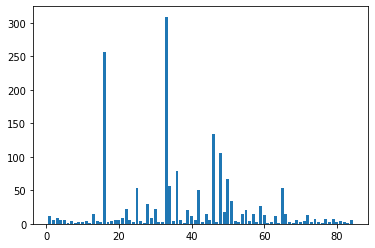

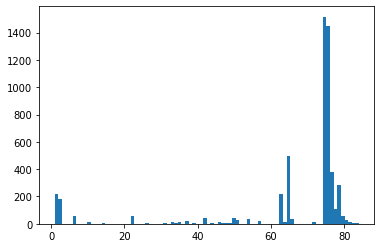

{1, 2, 6, 10, 11, 14, 18, 19, 22, 25, 26, 28, 29, 30, 31, 33, 34, 35, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 57, 63, 64, 65, 66, 69, 72, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84}


In [25]:
x = [v[0] for v in answer.values()]

plt.bar([i for i in range(1,number_of_bins+1)],[base[base['bin_id'] == i].shape[0] for i in range(1, number_of_bins+1)])
plt.show()
plt.hist(x, bins=number_of_bins)
plt.show()
print(set(x))

In [26]:
threshold = sorted([i[1] for i in answer.values()], reverse=True)[3000]
print(threshold)
#threshold = 0.15
counter = 0
def assign(row):
    global counter
    cnt = row['#anonymous_gsa_id']
    if(cnt in answer and answer[cnt][1] >= threshold):                
        counter += 1
        return answer[cnt][0]    
    return 0

unlabelled['pred'] = unlabelled.apply(lambda row:assign(row),axis=1)    
print(counter)

1.0
3569


In [27]:
df = unlabelled[unlabelled['pred']!=0][['#anonymous_gsa_id','pred']]
df.columns = ['#anonymous_gsa_id','bin_id']
to_biobox(pd.concat([base,df]), f"./Temp/{dataset_name}/improved")

In [28]:
# Evaluate                            
tax_bins = [i for i in range(0, number_of_bins)]
for i in range(0, number_of_bins):    
    base_seq = base[base['bin_id']==(i+1)]['#anonymous_gsa_id']            
    d = contigs[contigs['#anonymous_gsa_id'].isin(base_seq)]    
    tax_bins[i] = (d.groupby("bin_id")["bin_id"].count()).sort_values(ascending=False).index[0]            

counter = 0    
for index,row in df.iterrows():
    id1 = tax_bins[row['bin_id'] - 1]
    id2 = contigs[contigs['#anonymous_gsa_id'] == row['#anonymous_gsa_id']].head(1)['bin_id']
    id2 = id2.to_numpy()[0]      
    if(str(id1) == str(id2)):
        counter += 1
        
print(f'{round((100 * counter) / df.shape[0],2)} %          , {counter}')

0.28 %          , 10


In [379]:
!amber.py -g ./Temp/{dataset_name}/gold_standard \
-o ./Output/{dataset_name}/Assesment \
./Temp/{dataset_name}/metabat1_p95 \
./Temp/{dataset_name}/metabat2_p95 \
./Temp/{dataset_name}/improved                  

2021-08-02 14:57:14,218 INFO Loading Gold standard
2021-08-02 14:57:14,270 INFO Loading metabat1_p95
2021-08-02 14:57:14,288 INFO Loading metabat2_p95
2021-08-02 14:57:14,300 INFO Loading improved
2021-08-02 14:57:14,317 INFO Creating output directories
2021-08-02 14:57:14,319 INFO Evaluating Gold standard (sample gsa, genome binning)
2021-08-02 14:57:14,517 INFO Evaluating metabat1_p95 (sample gsa, genome binning)
2021-08-02 14:57:14,726 INFO Evaluating metabat2_p95 (sample gsa, genome binning)
2021-08-02 14:57:14,928 INFO Evaluating improved (sample gsa, genome binning)
2021-08-02 14:57:15,122 INFO Saving computed metrics
2021-08-02 14:57:15,153 INFO Creating genome binning plots
/home/emadi/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obj

# KEGG

In [ ]:
kegg = pd.read_csv('./Annotation/Toy_low/data/cds.gene2kegg.tab.txt',sep='\t')
print(kegg.shape)
kegg = pd.merge(kegg,Geneid2Contigid,how='inner',on='#Geneid')
kegg.head(2)

In [ ]:
print(np.median(list(kegg['Kegg_id'].value_counts())))
plt.plot(list(kegg['Kegg_id'].value_counts()))
plt.show()

# KO

In [ ]:
ko = pd.read_csv('./Annotation/Toy_low/data/cds.gene2ko.tab.txt',sep='\t')
print(ko.shape)
ko.head(5)

In [ ]:
print(np.median(list(ko['koid'].value_counts())))
plt.plot(list(ko['koid'].value_counts()))
plt.show()

In [ ]:
print(np.median(list(ko['Contig'].value_counts())))
plt.plot(list(ko['Contig'].value_counts()))
plt.show()

In [ ]:
df = pd.read_csv('./Annotation/Toy_low/data/cds.gene2sprot.tab.txt',sep='\t')
print(df.shape)
df.head(2)

In [ ]:
uniprot = pd.read_csv('./uniprot-filtered-reviewed-yes.tab',sep='\t')
print(uniprot.shape)
uniprot.head(2)

In [ ]:
df = pd.merge(uniprot,df,how='inner',left_on='Protein names',right_on='sprot_desc')
print(df.shape)
df.head(2)

In [ ]:
'''
source = []
target = []
weigth = []
tax =[]
for t in [75309, 328515,1120996]:
    df = pd.merge(contigs,go,how="inner",left_on="#anonymous_gsa_id", right_on = "#Gene")    
    df = df[df['tax_id']==t]    
    print(df.shape)
    TM = df['TM'].to_numpy()
    Go_id = df['go_id'].to_numpy()
    for i in range(0, len(TM)-1):
        for j in range(i+1, len(TM)):                
            if(TM[i] + TM[j] in bp_dictionary):
                if(bp_dictionary[TM[i] + TM[j]] > 0.7):
                    source.append(Go_id[i])
                    target.append(Go_id[j])
                    weigth.append(bp_dictionary[ TM[i] + TM[j]])            
                    tax.append(t)
df = pd.DataFrame({'source': source, 'target': target, 'weigth': weigth , 'tax': tax})
df.to_csv('./data.csv', index=None)
''';